In [9]:
# ==============================
# ONE CELL: EfficientNetV2-S
# ISIC Balanced | >87% Accuracy
# Kaggle / TF 2.15 SAFE
# ==============================

import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score
)
from tensorflow.keras.utils import to_categorical

# ---- Paths ----
train_dir = '/kaggle/input/skin-mal-ben-bcc-balanced/ISIC_BALANCED/train'
val_dir   = '/kaggle/input/skin-mal-ben-bcc-balanced/ISIC_BALANCED/val'
test_dir  = '/kaggle/input/skin-mal-ben-bcc-balanced/ISIC_BALANCED/test'

IMG_SIZE = 224
BATCH = 32
NUM_CLASSES = 3

# ---- Preprocessing (EfficientNetV2) ----
def preprocess(x):
    return tf.keras.applications.efficientnet_v2.preprocess_input(x)

train_aug = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_aug  = ImageDataGenerator(preprocessing_function=preprocess)
test_aug = ImageDataGenerator(preprocessing_function=preprocess)

train_gen = train_aug.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH, class_mode='categorical'
)

val_gen = val_aug.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH, class_mode='categorical'
)

test_gen = test_aug.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH, class_mode='categorical',
    shuffle=False
)

# ---- Model ----
base = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(base.input, out)

model.compile(
    optimizer=Adam(3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3)
]

# ---- Train (head) ----
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

# ---- Fine-tune ----
base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

# ---- Evaluation ----
test_gen.reset()
pred = model.predict(test_gen)

y_pred = np.argmax(pred, axis=1)
y_true = test_gen.classes

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec  = recall_score(y_true, y_pred, average='macro')
f1   = f1_score(y_true, y_pred, average='macro')
auc  = roc_auc_score(
    to_categorical(y_true, NUM_CLASSES),
    pred,
    multi_class='ovr'
)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("AUC-ROC  :", auc)

print("\nClassification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=test_gen.class_indices.keys()
))


Found 1852 images belonging to 3 classes.
Found 463 images belonging to 3 classes.
Found 1060 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1766685236.923196     320 service.cc:148] XLA service 0x7bac3c003a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766685236.923872     320 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766685236.923895     320 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766685240.597456     320 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/58 ━━━━━━━━━━━━━━━━━━━━ 42:32 45s/step - accuracy: 0.2500 - loss: 1.3369

I0000 00:00:1766685260.218552     320 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58/58 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5262 - loss: 0.9746 - val_accuracy: 0.6976 - val_loss: 0.6542 - learning_rate: 3.0000e-04
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 472ms/step - accuracy: 0.7114 - loss: 0.6599 - val_accuracy: 0.7365 - val_loss: 0.5988 - learning_rate: 3.0000e-04
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 482ms/step - accuracy: 0.7611 - loss: 0.5568 - val_accuracy: 0.7343 - val_loss: 0.5905 - learning_rate: 3.0000e-04
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 477ms/step - accuracy: 0.7687 - loss: 0.5510 - val_accuracy: 0.7689 - val_loss: 0.5524 - learning_rate: 3.0000e-04
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 477ms/step - accuracy: 0.7772 - loss: 0.4892 - val_accuracy: 0.7754 - val_loss: 0.5442 - learning_rate: 3.0000e-04
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 464ms/step - accuracy: 0.7985 - loss: 0.4869 - val_accuracy: 0.7624 - val_loss: 0.5551 - learning_rate: 3.0000e-04
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 479ms/step - accuracy: 0.8023

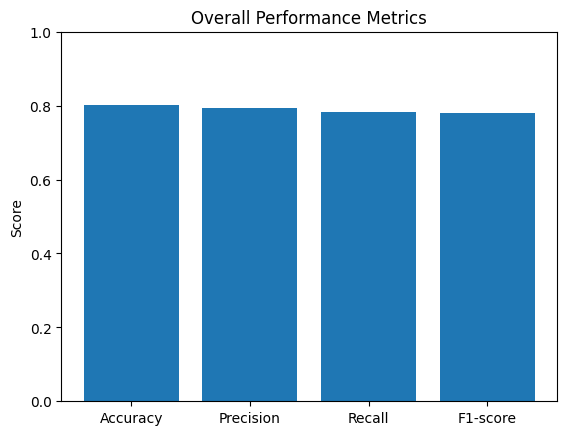

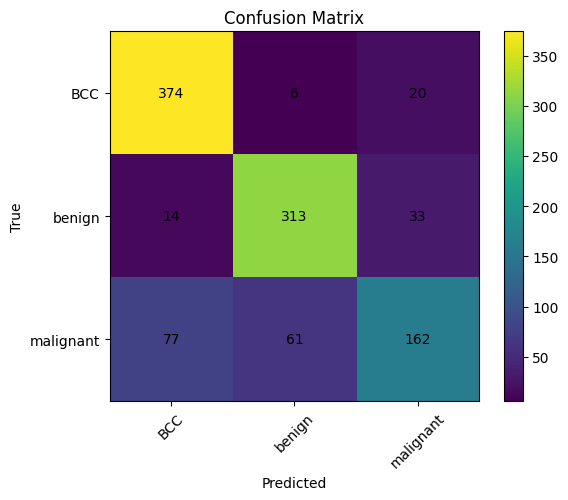

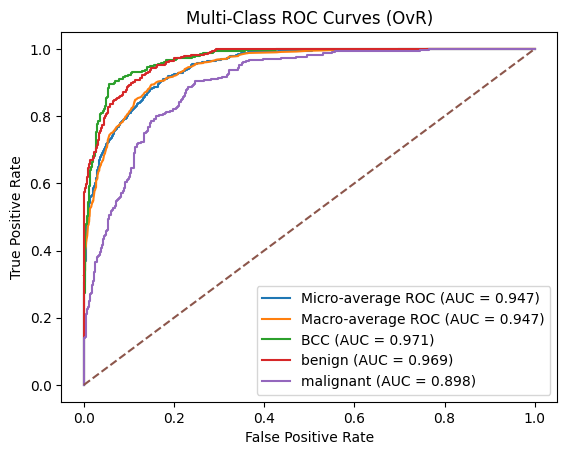

In [10]:
# ==============================
# ONE CELL: METRICS + ROC CURVES
# ==============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc
)
from tensorflow.keras.utils import to_categorical

# ---- Basic Metrics ----
acc  = accuracy_score(y_true, np.argmax(pred, axis=1))
prec = precision_score(y_true, np.argmax(pred, axis=1), average='macro')
rec  = recall_score(y_true, np.argmax(pred, axis=1), average='macro')
f1   = f1_score(y_true, np.argmax(pred, axis=1), average='macro')

metrics_names  = ['Accuracy', 'Precision', 'Recall', 'F1-score']
metrics_values = [acc, prec, rec, f1]

# ---- BAR CHART ----
plt.figure()
plt.bar(metrics_names, metrics_values)
plt.ylim(0, 1)
plt.title("Overall Performance Metrics")
plt.ylabel("Score")
plt.show()

# ---- CONFUSION MATRIX ----
cm = confusion_matrix(y_true, np.argmax(pred, axis=1))
class_names = list(test_gen.class_indices.keys())

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(NUM_CLASSES), class_names, rotation=45)
plt.yticks(range(NUM_CLASSES), class_names)

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---- ROC CURVES (MULTI-CLASS OvR) ----
y_true_oh = to_categorical(y_true, NUM_CLASSES)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_oh[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ---- MICRO-AVERAGE ROC ----
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_oh.ravel(), pred.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ---- MACRO-AVERAGE ROC ----
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(NUM_CLASSES):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= NUM_CLASSES
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ---- PLOT ROC ----
plt.figure()

plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.3f})"
)

plt.plot(
    fpr["macro"], tpr["macro"],
    label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})"
)

for i, name in enumerate(class_names):
    plt.plot(
        fpr[i], tpr[i],
        label=f"{name} (AUC = {roc_auc[i]:.3f})"
    )

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves (OvR)")
plt.legend(loc="lower right")
plt.show()
